
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Epoch: 1 DiscriminatorA Loss= 0.249987,DiscriminatorB Loss= 0.232720, Generator Loss= 0.468305, Avg Loss=0.882529
Epoch: 2 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.262391, Generator Loss= 0.417501, Avg Loss=0.901770
Epoch: 3 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.249856, Generator Loss= 0.381954, Avg Loss=0.835978
Epoch: 4 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.249988, Generator Loss= 0.353957, Avg Loss=0.799616
Epoch: 5 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.249994, Generator Loss= 0.341601, Avg Loss=0.770460
Epoch: 6 DiscriminatorA Loss= 0.250000,DiscriminatorB Loss= 0.249996, Generator Loss= 0.336188, Avg Loss=0.756736
Epoch: 7

C:\Users\my\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\my\Anaconda3\lib\site-packages\ipykernel_launcher.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\my\Anaconda3\lib\site-packages\ipykernel_launcher.py:205: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_war

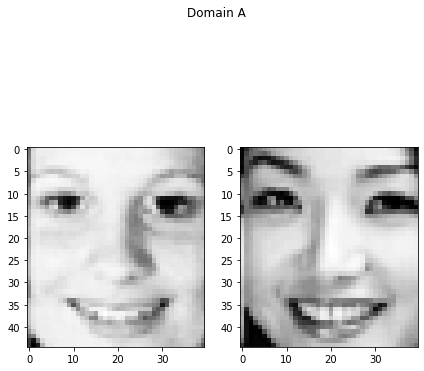

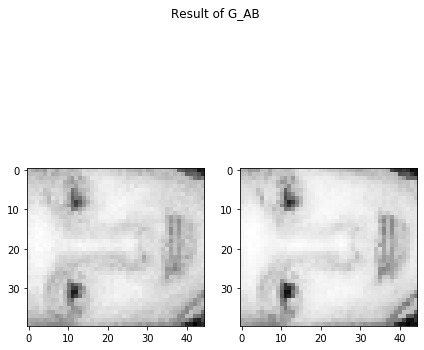

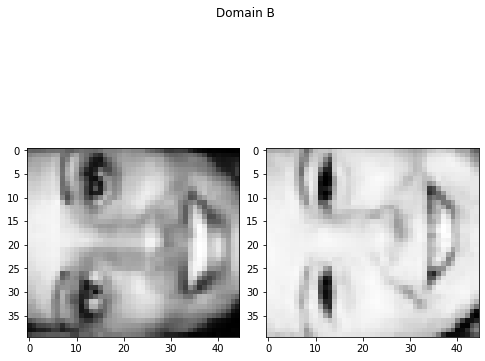

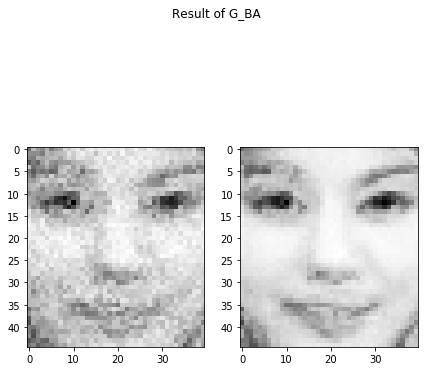

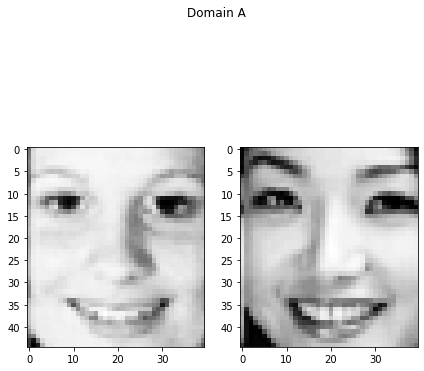

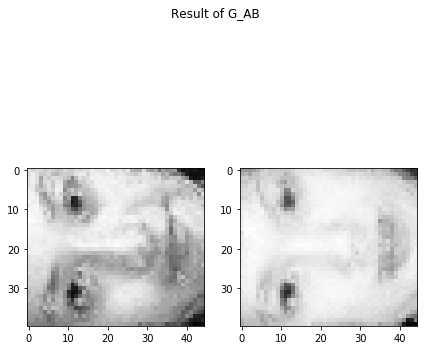

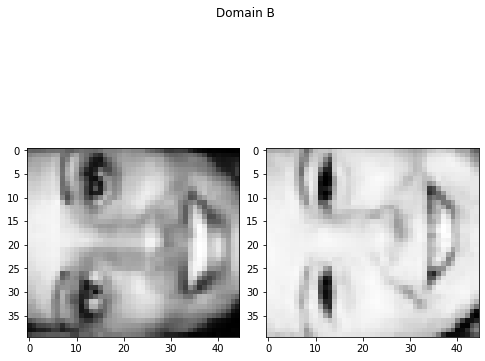

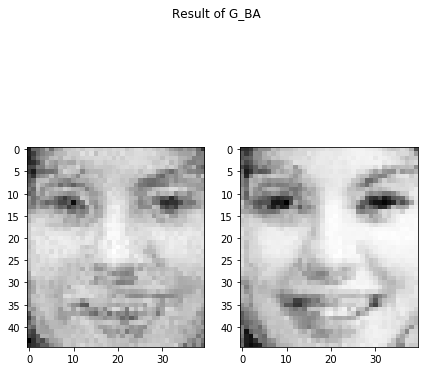

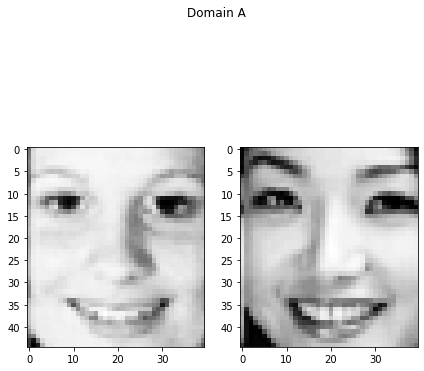

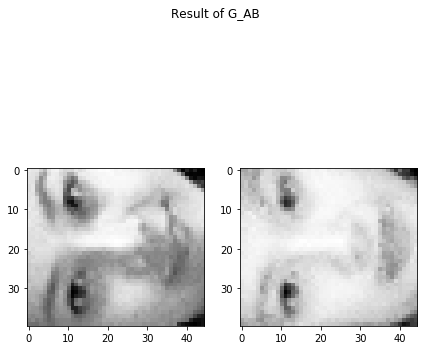

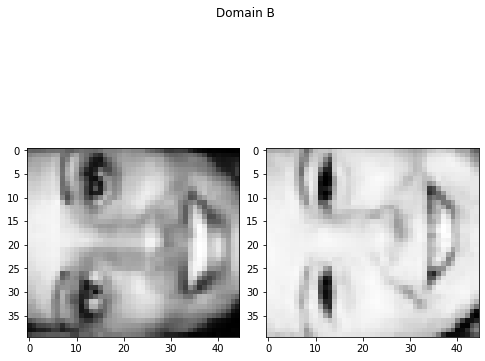

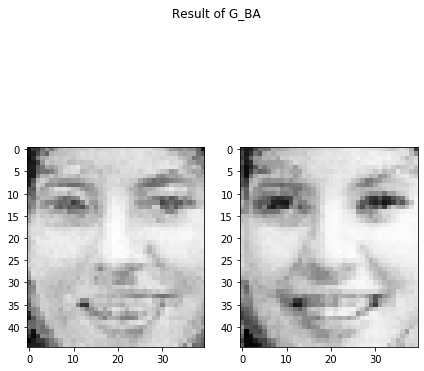

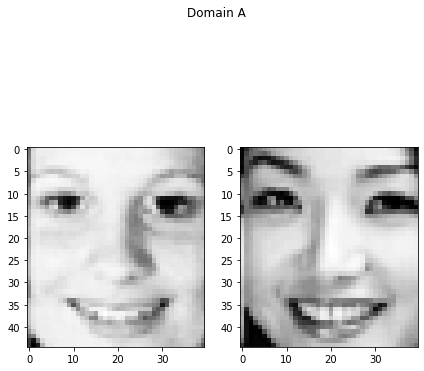

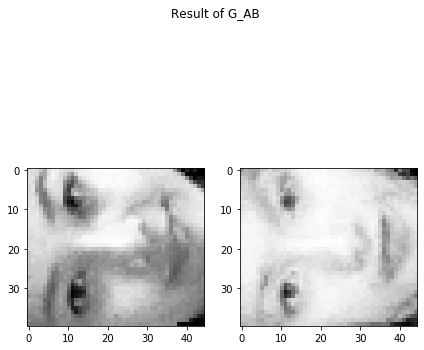

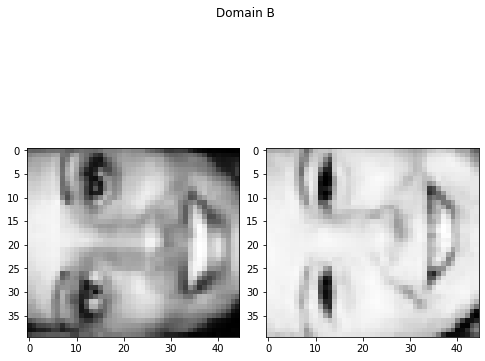

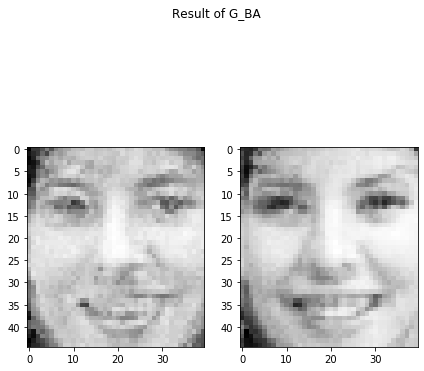

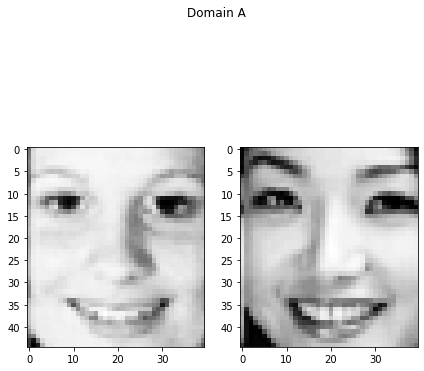

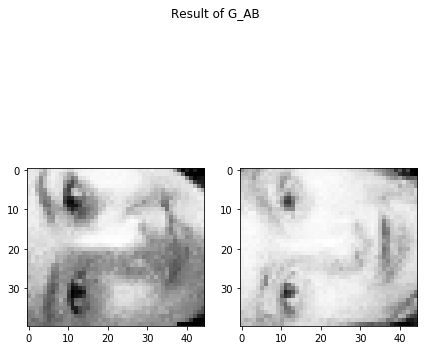

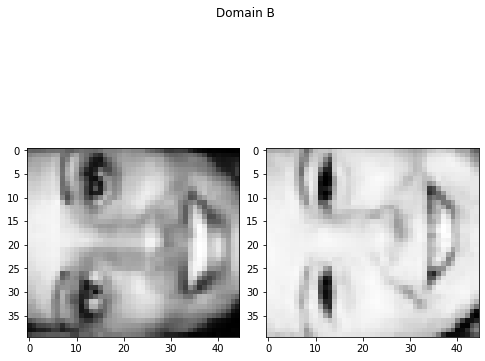

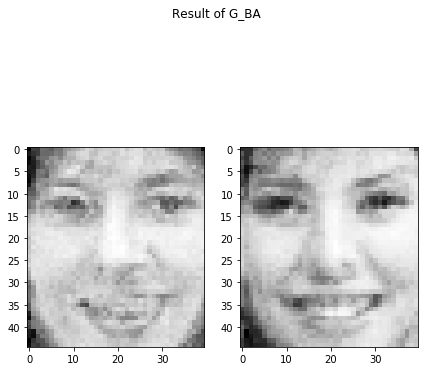

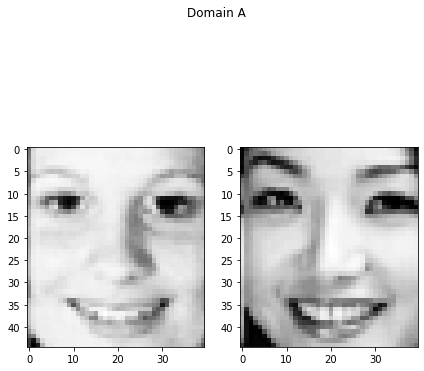

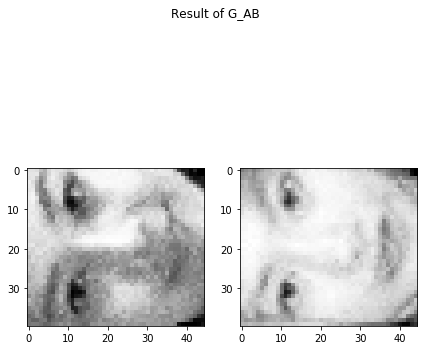

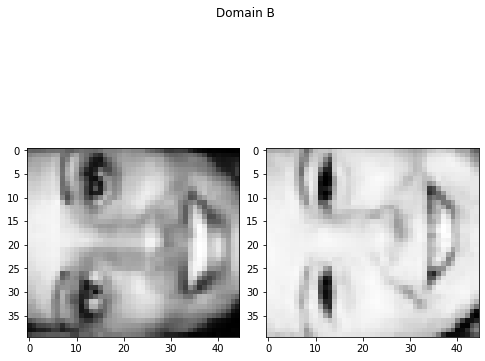

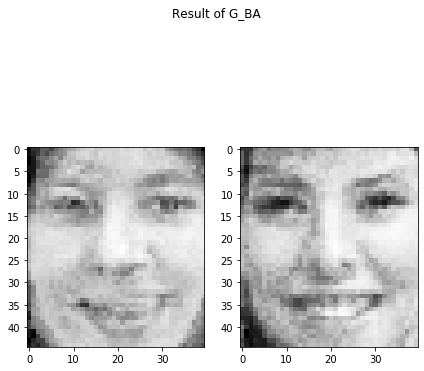

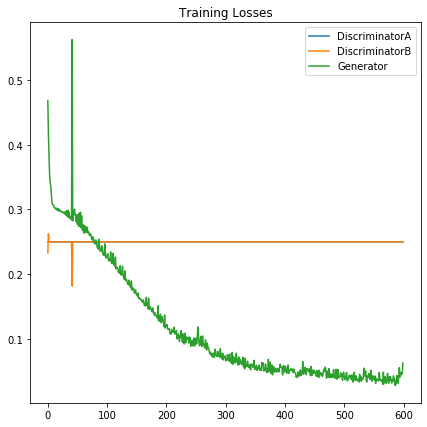

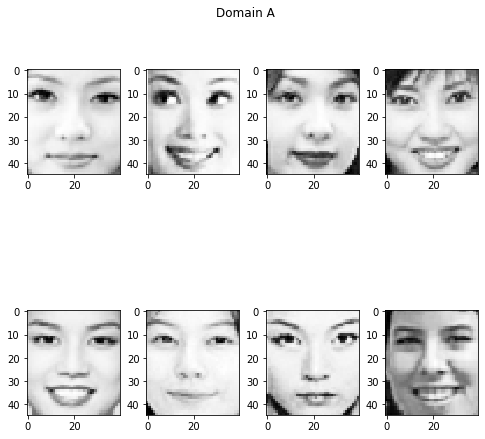

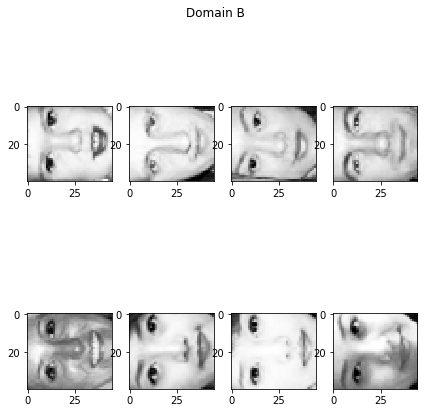

In [1]:
# 필요한 라이브러리 불러들임 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image as Im
import os
import glob  
%matplotlib inline

# 그래프 리셋
tf.reset_default_graph() 
# 재현성을 위해 시드 지정
tf.set_random_seed(1)

#--------------------------------------------------
# data 불러오기
#--------------------------------------------------
 
files=glob.glob('./face20/*.png')

img=[]          
for file in files:
    a=Im.open(file) 
    a=a.convert('L') # 흑백화면으로 
    a1=np.array(a)
    img.append(a1)        
    

xr=np.asarray(img)/255. # convert list to array

nr=np.prod(xr.shape[1:3]) # 45*40=1800
Xr=np.reshape(xr,[len(img),nr]) #=[20,1800]


import scipy.ndimage.interpolation
# Real image
X_rA = Xr[:10]
# Rotated image
X_rB = Xr[10:].reshape(-1, 45, 40)
X_rB = scipy.ndimage.interpolation.rotate(X_rB, 90, axes=(1, 2))
X_rB = X_rB.reshape(-1, 45*40)

# divide to train and test
XA=X_rA[0:2,:]
X_trainA=X_rA[2:10,:]
XB=X_rB[0:2,:]
X_trainB=X_rB[2:10,:]

# 훈련용과 시험용 이미지 개수와 입력 변수의 수
sample_size= X_trainA.shape[0] #8 
sample_size_test= XA.shape[0] #2 
X_dim = X_trainA.shape[1] #=1800
#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
# 생성자의 두 은닉층 크기: 128
# 비판자의 두 은닉층 크기: 128
# 미니배치 크기: 20
# 반복 수: 300
# 학습률 : 0.001

learning_rate = 0.001
batch_size = 2
epochs =600 # no. of epochs
h_dim = 128

# 입력 이미지 placeholder
X_A = tf.placeholder(tf.float32, shape=[None, X_dim])
X_B = tf.placeholder(tf.float32, shape=[None, X_dim])


# 판별자의 가중치와 편의(# 사비에르 초기치 사용)
D_A_W1 = tf.get_variable('D_A_W1',shape=[X_dim, h_dim],initializer=tf.contrib.layers.xavier_initializer())
D_A_b1 = tf.Variable(tf.zeros([h_dim]))
D_A_W2 = tf.get_variable('D_A_W2', shape=[h_dim, 1],initializer=tf.contrib.layers.xavier_initializer())
D_A_b2 = tf.Variable(tf.zeros([1]))

D_B_W1 = tf.get_variable('D_B_W1', shape=[X_dim, h_dim],initializer=tf.contrib.layers.xavier_initializer())
D_B_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
D_B_W2 = tf.get_variable('D_B_W2', shape=[h_dim, 1],initializer=tf.contrib.layers.xavier_initializer())
D_B_b2 = tf.Variable(tf.zeros([1]))

# 생성자의 가중치와 편의(# 사비에르 초기치 사용)
G_AB_W1 = tf.get_variable('D_AB_W1', shape=[X_dim, h_dim],initializer=tf.contrib.layers.xavier_initializer())
G_AB_b1 = tf.Variable(tf.zeros([h_dim]))
G_AB_W2 = tf.get_variable('D_AB_W2', shape=[h_dim, X_dim],initializer=tf.contrib.layers.xavier_initializer())
G_AB_b2 = tf.Variable(tf.zeros([X_dim]))

G_BA_W1 = tf.get_variable('D_BA_W1', shape=[X_dim, h_dim],initializer=tf.contrib.layers.xavier_initializer())
G_BA_b1 = tf.Variable(tf.zeros([h_dim]))
G_BA_W2 = tf.get_variable('D_BA_W2', shape=[h_dim, X_dim],initializer=tf.contrib.layers.xavier_initializer())
G_BA_b2 = tf.Variable(tf.zeros([X_dim]))


# 모수 모음
theta_DA = [D_A_W1, D_A_W2, D_A_b1, D_A_b2]
theta_DB= [ D_B_W1, D_B_W2, D_B_b1, D_B_b2]
theta_G = [G_AB_W1, G_AB_W2, G_AB_b1, G_AB_b2,
           G_BA_W1, G_BA_W2, G_BA_b1, G_BA_b2]

#------------------------------------------------
# 생성자 정의:
#------------------------------------------------
def G_AB(X):
    h1 = tf.nn.relu(tf.matmul(X, G_AB_W1) + G_AB_b1)
    return tf.nn.sigmoid(tf.matmul(h1, G_AB_W2) + G_AB_b2)


def G_BA(X):
    h1 = tf.nn.relu(tf.matmul(X, G_BA_W1) + G_BA_b1)
    return tf.nn.sigmoid(tf.matmul(h1, G_BA_W2) + G_BA_b2)

#------------------------------------------------
# 판별자 정의:
#------------------------------------------------
def D_A(X):
    h1 = tf.nn.relu(tf.matmul(X, D_A_W1) + D_A_b1)
    return tf.nn.sigmoid(tf.matmul(h1, D_A_W2) + D_A_b2)


def D_B(X):
    h1 = tf.nn.relu(tf.matmul(X, D_B_W1) + D_B_b1)
    return tf.nn.sigmoid(tf.matmul(h1, D_B_W2) + D_B_b2)



# 생성(변형)결과 
X_AB = G_AB(X_A)
X_BA = G_BA(X_B)


# 판별자 D_A 결과 
D_A_real = D_A(X_A)
D_A_fake = D_A(X_BA)

# 판별자 D_B 결과
D_B_real = D_B(X_B)
D_B_fake = D_B(X_AB)

# 복원( x -> G(x)-> F(G(x)-> x))
X_ABA = G_BA(X_AB)

# 복원( y -> F(x)-> G(F(x)-> y))
X_BAB = G_AB(X_BA)


# 판별자 비용함수 (LSGAN 적용)
DA_loss = 0.5 * (tf.reduce_mean((D_A_real - 1)**2)+ 0.5*tf.reduce_mean(D_A_fake**2))
DB_loss = 0.5 * (tf.reduce_mean((D_B_real - 1)**2)+ 0.5*tf.reduce_mean(D_B_fake**2))

# 생성자 비용함수
GAB_loss = 0.5 * tf.reduce_mean((D_A_fake - 1)**2)+0.5 * tf.reduce_mean((D_B_fake - 1)**2)

# 복원에 대한 비용함수
C_loss=tf.reduce_mean(tf.abs(X_A-X_ABA))+tf.reduce_mean(tf.abs(X_B-X_BAB))
G_loss=GAB_loss+C_loss


# Optimizer
DA_solver = tf.train.AdamOptimizer(learning_rate).minimize(DA_loss, var_list=theta_DA)
DB_solver = tf.train.AdamOptimizer(learning_rate).minimize(DB_loss, var_list=theta_DB)
G_solver = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=theta_G)


#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
sess=tf.Session(); 
sess.run(tf.global_variables_initializer())
losses = []
for epoch in range(epochs):
    total_batch=int(sample_size/batch_size)
    avg_loss=0
    for ii in range(total_batch):
        if ii!=total_batch:
            XrA=X_trainA[ii*batch_size:(ii+1)*batch_size]
            XrB=X_trainB[ii*batch_size:(ii+1)*batch_size]
        else:
            XrA=X_trainA[(ii+1)*batch_size:]           
            XrB=X_trainB[(ii+1)*batch_size:]         
        DA_loss_curr,_ = sess.run([DA_loss,DA_solver], feed_dict={X_A: XrA, X_B: XrB})
        DB_loss_curr,_ = sess.run([DB_loss,DB_solver], feed_dict={X_A: XrA, X_B: XrB})
        G_loss_curr,_ = sess.run([G_loss,G_solver], feed_dict={X_A: XrA, X_B: XrB})    
        losss=DA_loss_curr+DB_loss_curr+G_loss_curr
        avg_loss+=losss/total_batch
    print('Epoch: %d' %(epoch+1),
          'DiscriminatorA Loss= %f,DiscriminatorB Loss= %f, Generator Loss= %f, Avg Loss=%f'
          %(DA_loss_curr, DB_loss_curr,G_loss_curr, avg_loss))
    losses.append((DA_loss_curr, DB_loss_curr,G_loss_curr,avg_loss))
    # 100 에폭마다 변형되는 이미지 그림
    if (epoch+1)%100==0:  
        samples_A = sess.run(X_BA, feed_dict={X_B: XB})
        samples_B = sess.run(X_AB, feed_dict={X_A: XA})
        # 도메인  A의 test 이미지
        f,axes =plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)
        for ii in range(2):
            plt.subplot(1,2,ii+1); plt.suptitle('Domain A') 
            plt.imshow(XA[ii].reshape(45,40),'Greys_r')
        # G_AB(X_A) 결과               
        f,axes =plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)      
        for ii in range(2):
            plt.subplot(1,2,ii+1); plt.suptitle('Result of G_AB') 
            plt.imshow(samples_B[ii].reshape(40,45),'Greys_r')
        # 도메인  B의 test 이미지
        f,axes =plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        f.tight_layout()
        for ii in range(2):
            plt.subplot(1,2,ii+1);plt.suptitle('Domain B') 
            plt.imshow(XB[ii].reshape(40,45),'Greys_r')
        # G_BA(X_B) 결과          
        f,axes =plt.subplots(figsize=(7,7), nrows=1, ncols=2, sharey=True, sharex=True)     
        for ii in range(2):
            plt.subplot(1,2,ii+1);plt.suptitle('Result of G_BA') 
            plt.imshow(samples_A[ii].reshape(45,40),'Greys_r')  
            
# 판별자, 생성자의 비용함수 그림 
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='DiscriminatorA')
plt.plot(losses.T[1], label='DiscriminatorB')
plt.plot(losses.T[2], label='Generator')
plt.title("Training Losses")
plt.legend()


# 도메인 A 에 속하는 이미지
f,axes =plt.subplots(figsize=(7,7), nrows=2, ncols=4, sharey=True, sharex=True)
f.tight_layout()
for ii in range(8):
    plt.subplot(2,4,ii+1); f.suptitle('Domain A')
    plt.imshow(X_trainA[ii].reshape(45,40),'Greys_r')

# 도메인 B 에 속하는 이미지    
f,axes =plt.subplots(figsize=(7,7), nrows=2, ncols=4, sharey=True, sharex=True)
for ii in range(8):
    plt.subplot(2,4,ii+1); f.suptitle('Domain B') 
    plt.imshow(X_trainB[ii].reshape(40,45),'Greys_r')